In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get the data
import zipfile
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-10-13 18:12:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.207, 142.250.152.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   208MB/s    in 0.8s    

2023-10-13 18:12:28 (208 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os
# Walk through the 10 percent of the data
for dirpath,dirnames,filenames in os.walk("/content/10_food_classes_10_percent/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


There are 2 directories and 0 images in /content/10_food_classes_10_percent/
There are 10 directories and 0 images in /content/10_food_classes_10_percent/train
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in /content/10_food_classes_10_percent/train/chicken_curry
T

### Creating data loaders ( Preparing the data)

In [ ]:
# use ImageDataGenerator and flow_from_directory to load the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=(1/255.))
test_datagen = ImageDataGenerator(rescale=(1/255.))

print("Training Images")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


### Setting up callbacks
There are 3 kinds of this:
1. Experiment tracking with tensorboard: Log the performance of multiple models and then view and compare these models

2. Model Checkpoint: save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.

3. Early Stopping: Leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve.
Helpful when you've got a large dataset and don't know how long training will take.

In [ ]:
# Let's create a callback function for Tensorboard function
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving Tensorboard log files to {log_dir}")
  return tensorboard_callback

### Creating models using Tensorflow hub
We will create two models:
1. EfficientNetB0
2. ResnetV2

### Different Types of Transfer Learning
1. **"As is"**: using an existing model with no changes (e.g. Using ImageNet model on 1000 ImageNet classes and none of your own)

2. **"Feature Extraction Model"**: use the pre-learned patterns of existing model (eg. EfficientNet on ImageNet) and using the output layer for your own problem (1000 classes -> 10 food classes)

3. **"Fine-Tuning**: Use the prelearned model and "fine-tune" the many or all underlying layers (including the output layers)

A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).
After you've trained the top 2-3 layers, you can then gradually "unfreeze" more and more layers and run the training process on your own data to further fine-tune the pretrained model.

* The lower a layer is in a computer vision model as in, the closer it is to the input layer, the larger the features it learn. For example, a bottom layer in a computer vision model to identify images of cats or dogs might learn the outline of legs, where as, layers closer to the output might learn the shape of teeth. Often, you'll want the larger features (learned patterns are also called features) to remain, since these are similar for both animals, where as, the differences remain in the more fine-grained features.

* The different kinds of transfer learning. An original model, a feature extraction model (only top 2-3 layers change) and a fine-tuning model (many or all of original model get changed).

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's setup the urls for resnet and efficient net
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [ ]:
# Now we can use Keras_Layer() to make it unfold like Sequential Layers
def create_model(model_url,num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the underlying patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Define the input shape as it is the first layer
  # Create our model
  model = tf.keras.Sequential([
      feature_extractor_layer, # Use the feature extraction layer as base
      layers.Dense(num_classes, activation='softmax',name="output_layer") # Create our own output layer
  ])
  return model


In [ ]:
IMAGE_SHAPE, IMAGE_SHAPE + (3,)

((224, 224), (224, 224, 3))

In [ ]:
# Create the model
resnet_model = create_model(resnet_url,num_classes=train_data.num_classes)

# Compile the model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
# Let's fit the model
resnet_history = resnet_model.fit(train_data,
                 epochs=EPOCHS,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnetv2")])

Saving Tensorboard log files to tensorflow_hub/resnetv2/20231013-194903
Epoch 1/5
24/24 [==============================] - 11s 450ms/step - loss: 0.1496 - accuracy: 0.9893 - val_loss: 0.6074 - val_accuracy: 0.7948
Epoch 2/5
24/24 [==============================] - 11s 473ms/step - loss: 0.1308 - accuracy: 0.9933 - val_loss: 0.6117 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 12s 512ms/step - loss: 0.1151 - accuracy: 0.9960 - val_loss: 0.6039 - val_accuracy: 0.7992
Epoch 4/5
24/24 [==============================] - 11s 469ms/step - loss: 0.1023 - accuracy: 0.9960 - val_loss: 0.6026 - val_accuracy: 0.7944
Epoch 5/5
24/24 [==============================] - 13s 548ms/step - loss: 0.0929 - accuracy: 0.9960 - val_loss: 0.6020 - val_accuracy: 0.7976


In [ ]:
# Let's plot our history curves
import matplotlib.pyplot as plt
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.figure()
  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curves")
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title("Accuracy Curves")
  plt.legend()

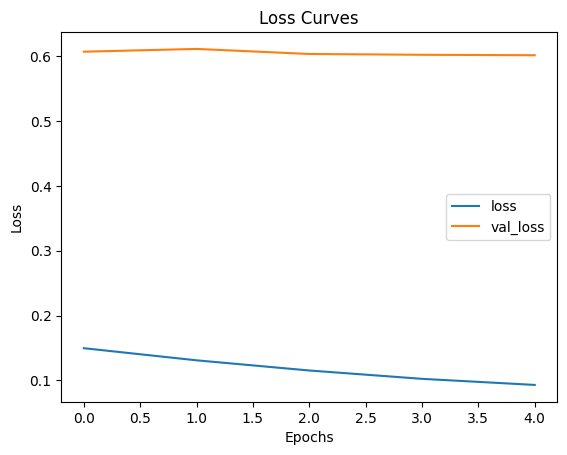

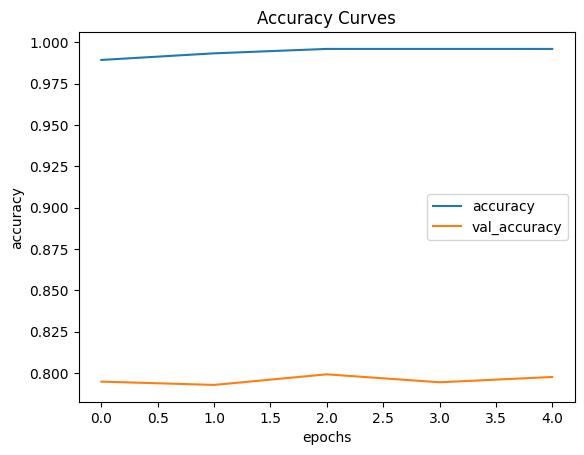

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Now let's create our efficient net model
efficientnet_model = create_model(efficientnet_url,num_classes=train_data.num_classes)

# Let's compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer="adam",
                           metrics="accuracy")
# Let's fit the model
history_efficientnet = efficientnet_model.fit(train_data,
                       epochs=EPOCHS,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name="tensflow_hub",experiment_name="efficientnetb0")])

Saving Tensorboard log files to tensflow_hub/efficientnetb0/20231013-200310
Epoch 1/5
24/24 [==============================] - 21s 577ms/step - loss: 1.9902 - accuracy: 0.3627 - val_loss: 1.5474 - val_accuracy: 0.5904
Epoch 2/5
24/24 [==============================] - 12s 535ms/step - loss: 1.3300 - accuracy: 0.6813 - val_loss: 1.1349 - val_accuracy: 0.7084
Epoch 3/5
24/24 [==============================] - 10s 430ms/step - loss: 1.0250 - accuracy: 0.7507 - val_loss: 0.9518 - val_accuracy: 0.7368
Epoch 4/5
24/24 [==============================] - 10s 433ms/step - loss: 0.8556 - accuracy: 0.7880 - val_loss: 0.8565 - val_accuracy: 0.7584
Epoch 5/5
24/24 [==============================] - 11s 459ms/step - loss: 0.7476 - accuracy: 0.8200 - val_loss: 0.7952 - val_accuracy: 0.7664


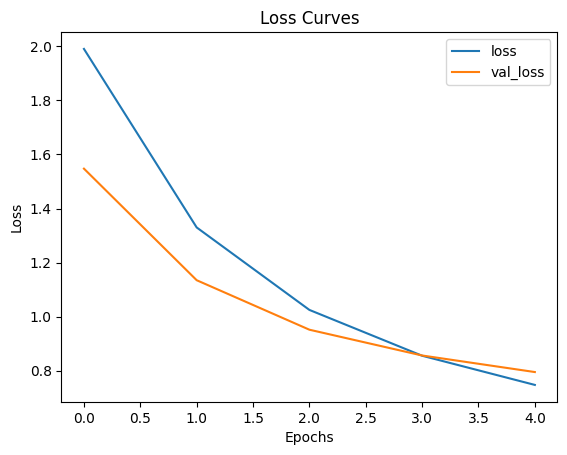

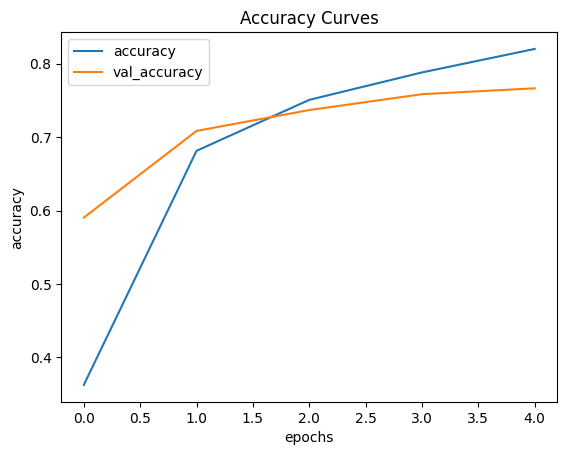

In [ ]:
plot_loss_curves(history_efficientnet)

In [ ]:
# Let's test our data in MobileNetV2
mobilenetv2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

# Create model
mobilev2 = create_model(mobilenetv2,num_classes=train_data.num_classes)

mobilev2.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics='accuracy')
history_mobilenet = mobilev2.fit(train_data,
             epochs=EPOCHS,
             steps_per_epoch=len(train_data),
             validation_data=test_data,
             validation_steps=len(test_data),
             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="mobile_netv2")])

Saving Tensorboard log files to tensorflow_hub/mobile_netv2/20231013-202010
Epoch 1/5
24/24 [==============================] - 19s 568ms/step - loss: 1.9017 - accuracy: 0.3640 - val_loss: 1.3013 - val_accuracy: 0.6208
Epoch 2/5
24/24 [==============================] - 12s 535ms/step - loss: 1.0156 - accuracy: 0.7107 - val_loss: 0.8999 - val_accuracy: 0.7356
Epoch 3/5
24/24 [==============================] - 9s 395ms/step - loss: 0.7259 - accuracy: 0.8040 - val_loss: 0.7750 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 9s 396ms/step - loss: 0.5830 - accuracy: 0.8467 - val_loss: 0.6966 - val_accuracy: 0.7844
Epoch 5/5
24/24 [==============================] - 10s 420ms/step - loss: 0.4804 - accuracy: 0.8893 - val_loss: 0.6573 - val_accuracy: 0.7908


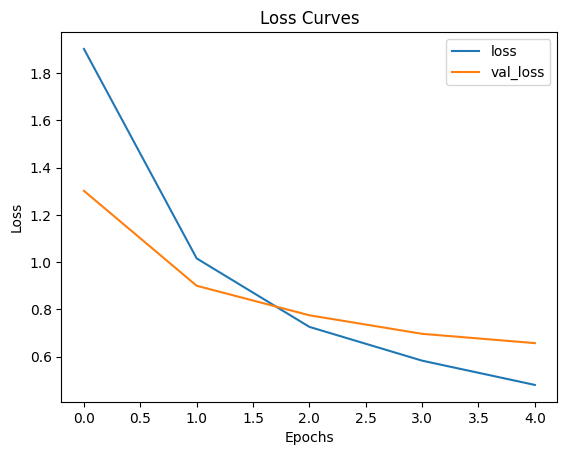

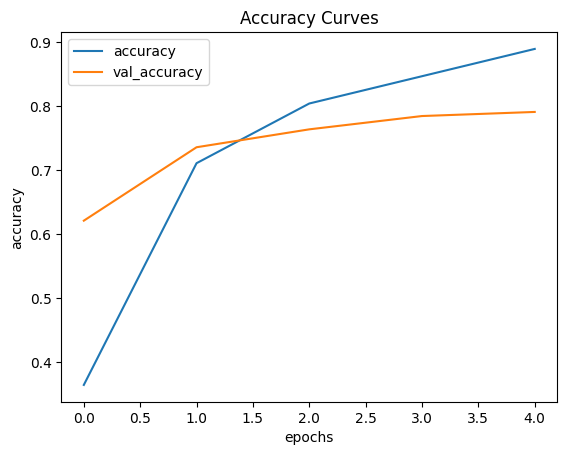

In [ ]:
plot_loss_curves(history_mobilenet)